## CMPINF 2100 Week 14

### Extra: Regularization for Regression problems using Pipeline

The lecture example focused on Classification but Regularization is also important for regression problems! This notebook shows the functions specific for Lasso, Ridge, and Elastic net for regression.

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Read data

Let's use the Week 11 linear additive inputs example.

In [2]:
df11 = pd.read_csv('../week_11/linear_additive_example.csv')

In [3]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      35 non-null     float64
 1   x2      35 non-null     float64
 2   trend   35 non-null     float64
 3   y       35 non-null     float64
dtypes: float64(4)
memory usage: 1.2 KB


Drop the `trend` column so the data only consists of output and inputs.

In [4]:
df = df11.drop(columns={'trend'}).copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      35 non-null     float64
 1   x2      35 non-null     float64
 2   y       35 non-null     float64
dtypes: float64(3)
memory usage: 968.0 bytes


## Model training

We will use scikit-learn to fit the linear model for regression. Start with the "regular" un-regularized linear model.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
from patsy import dmatrices

We will use cross-validation to assess the performance.

In [8]:
from sklearn.model_selection import KFold

Use 5-fold CV for this example.

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=51231)

In [10]:
kf.get_n_splits()

5

Use `cross_val_score()` to manage the cross-validation.

In [11]:
from sklearn.model_selection import cross_val_score

### Design matrix or Feature array

Let's use `dmatrices()` to create the feature array associated with the complex model we trained back in Week 11. This model derives non-linear features from both continuous inputs and interacts all continuous input features.

In [12]:
y_sk, X_sk = dmatrices('y ~ ( x1 + np.power(x1, 2) ) * ( x2 + np.power(x2, 2) )', data = df)

We will use the "hack" which instructs scikit-learn to fit the intercept with the rest of the coefficients. The model is FIT on the entire data set below.

In [13]:
fit_sk = LinearRegression(fit_intercept=False).fit( X_sk, y_sk.ravel() )

In [14]:
fit_sk.coef_

array([ 0.04839036,  1.35594571, -0.28799167, -0.03034037, -0.06138831,
       -0.22969466,  0.64188664, -0.2293035 ,  0.45887393])

We would get the SAME coefficients if we fit the model in statsmodels!

In [15]:
import statsmodels.formula.api as smf

In [16]:
fit_stats = smf.ols(formula='y ~ ( x1 + np.power(x1, 2) ) * ( x2 + np.power(x2, 2) )', data = df).fit()

In [17]:
fit_stats.params

Intercept                          0.048390
x1                                 1.355946
np.power(x1, 2)                   -0.287992
x2                                -0.030340
np.power(x2, 2)                   -0.061388
x1:x2                             -0.229695
x1:np.power(x2, 2)                 0.641887
np.power(x1, 2):x2                -0.229303
np.power(x1, 2):np.power(x2, 2)    0.458874
dtype: float64

However, we do NOT know how well the model performs on NEW data! Let's use cross-validation to find out! Initialize the scikit-learn linear model object below.

In [18]:
sk_like_stats = LinearRegression(fit_intercept=False)

The `cross_val_score()` method is used to estimate the AVERAGE holdout set R-squared for this model.

In [19]:
cross_val_score( sk_like_stats, X_sk, y_sk.ravel(), cv=kf).mean()

0.6960632715755448

Alternatively, we can calculate the average holdout set RMSE.

In [20]:
(-cross_val_score( sk_like_stats, X_sk, y_sk.ravel(), cv=kf, scoring='neg_root_mean_squared_error' )).mean()

0.7877461348100824

## Regularization

Without executing cross-validation on OTHER models, we do NOT have context around if this is the BEST we can do! We do NOT know if we need ALL features in this model from cross-validation alone! That's where REGULARIZATION or PENALIZATION helps!

We will use RIDGE, LASSO, and Elastic Net just as we used for the classification. There are two main differences for using these approaches for regression compared to classification in scikit-learn. First, the three methods are dictated by the `penalty` argument in `LogisticRegression()` for classification. That is **NOT** how the penalties are applied for regression! The `LinearRegression()` function does NOT penalize! Instead there are dedicated functions. The second major difference is the primary parameter is NOT named `C`. The primary tuning parameter that controls the regularization is named `alpha`. The `alpha` parameter is analogous to the `C` parameter but it is specified slightly differently. It is unfortunate that scikit-learn does this.

### Ridge

The `Ridge()` function is imported below.

In [21]:
from sklearn.linear_model import Ridge

The `alpha` parameter is analogous to the `C` parameter, but it is essentially the INVERSE of `C`. Meaning, large values of `alpha` cause the coefficients to become SMALL while small values of `alpha` allow the coefficients to be LARGE. Small values of `alpha` are analogous to estimating the coefficients to MINIMIZE the LOSS only and thus will be close to the `smf.ols()` estimates. 

Let's confirm the behavior of the `alpha` parameter by fitting Ridge penalized linear model with 3 different `alpha` values. Let's begin with the DEFAULT behavior which corresponds to an `alpha` of 1. The "hack" is used and so the `fit_intercept` argument must be set to `False`.

In [22]:
ridge_default_alpha = Ridge(alpha=1, fit_intercept=False).fit( X_sk, y_sk.ravel() )

In [23]:
ridge_default_alpha.coef_

array([ 0.02266076,  1.32276162, -0.23672364, -0.02123872, -0.06067722,
       -0.17060704,  0.595354  , -0.19361659,  0.41174542])

The default score is R-squared. The R-squared for the default `alpha` is below.

In [24]:
ridge_default_alpha.score( X_sk, y_sk.ravel() )

0.9198846692216772

Next, let's use a very small value for `alpha`.

In [25]:
ridge_small_alpha = Ridge(alpha=0.0001, fit_intercept=False).fit( X_sk, y_sk.ravel() )

In [26]:
ridge_small_alpha.coef_

array([ 0.048387  ,  1.35594309, -0.2879853 , -0.03033912, -0.06138819,
       -0.22968724,  0.6418803 , -0.22929903,  0.45886792])

These coefficients are VERY close to the `smf.ols()` estimates from before! Thus, small `alpha` values produce estimates similar to estimating the coefficients by MINIMIZING the LOSS (or without a penalty)!

In [27]:
fit_stats.params

Intercept                          0.048390
x1                                 1.355946
np.power(x1, 2)                   -0.287992
x2                                -0.030340
np.power(x2, 2)                   -0.061388
x1:x2                             -0.229695
x1:np.power(x2, 2)                 0.641887
np.power(x1, 2):x2                -0.229303
np.power(x1, 2):np.power(x2, 2)    0.458874
dtype: float64

The R-squared associated with the very small `alpha` is provided below.

In [28]:
ridge_small_alpha.score( X_sk, y_sk.ravel() )

0.9208033503973827

This R-squared is the same (within rounding error) as the R-squared for statsmodels because very small `alpha` behaves like estimating the coefficients to MINIMIZE the LOSS!

In [29]:
fit_stats.rsquared

0.9208033504088864

Lastly, let's estimate the coefficients with a very LARGE `alpha`.

In [30]:
ridge_large_alpha = Ridge(alpha=10000, fit_intercept=False).fit( X_sk, y_sk.ravel() )

In [31]:
ridge_large_alpha.coef_

array([-0.00028153,  0.00606667,  0.00062285, -0.00047348, -0.00298792,
        0.00388454,  0.00897516, -0.0006166 , -0.00270906])

These coefficients are SMALL! They are close to ZERO in magnitude!

The `Ridge()` function therefore behaves just analogously to `LogisticRegression()` with `penalty='l2'`! The impact of `alpha` is the INVERSE of `C` but the ideas are the same!

Since the coefficients have been pushes nearly to zero, the model has NO trends with respect to the inputs. The R-squared is therefore very close to zero!

In [32]:
ridge_large_alpha.score( X_sk, y_sk.ravel() )

0.020866757530101587

Which value of `alpha` should we use? We don't know! We must **TUNE** `alpha` via cross-validation! There is a built-in CV method for tuning `alpha` for Ridge named `RidgeCV()`.

In [33]:
from sklearn.linear_model import RidgeCV

The arguments to `RidgeCV()` are similar to `LogisticRegressionCV()`. However, the `alpha` values can be specified as the NUMBER of `alpha` via the `n_alpha` argument **or** by providing an array of values via the `alphas` argument. Let's specify an array to serve as a grid of values. The cell below uses `np.linspace()` to define an array with 101 evenly spaced values between -5 and 5 and then applies the `np.exp()` function. 

In [34]:
alpha_grid = np.exp( np.linspace(-5, 5, num=101) )

In [35]:
alpha_grid.shape

(101,)

The 5-fold cross-validation scheme is applied to tune the `alpha` parameter.

In [36]:
ridge_cv = RidgeCV( alphas=alpha_grid, fit_intercept=False, cv=kf).fit( X_sk, y_sk.ravel() )

The optimal `alpha` value is extracted via the `.alpha_` attribute.

In [37]:
ridge_cv.alpha_

0.36787944117144233

The default score (performance metric) is R-squared. The best cross-validation AVERAGE R-squared is provided below.

In [38]:
ridge_cv.best_score_

0.6974526220549084

The coefficients associated with the tuned `alpha` are shown below.

In [39]:
ridge_cv.coef_

array([ 0.03726896,  1.34511943, -0.26654287, -0.02629925, -0.06101418,
       -0.20479914,  0.62129262, -0.21431655,  0.43884724])

### Lasso

Lasso penalized linear models also have their own dedicated function, `Lasso()`. This function is imported below.

In [40]:
from sklearn.linear_model import Lasso

It has the SAME functionality as `Ridge()` except it also has a `max_iter` argument. I like to set `max_iter` when calling `Lasso()`. The default `alpha` value of 1 is used below.

In [41]:
lasso_default_alpha = Lasso(alpha=1, fit_intercept=False, max_iter=25001).fit( X_sk, y_sk.ravel() )

The LASSO penalty is capable of TURNING OFF features! Lasso does this by setting the coefficients to be IDENTICALLY zero! The default `alpha` value of 1 forced NEARLY all coefficients to be zero!

In [42]:
lasso_default_alpha.coef_

array([ 0.        ,  0.42483151,  0.        ,  0.        , -0.        ,
        0.        ,  0.29405064,  0.        ,  0.        ])

The R-squared associated with the default `alpha` Lasso model is below.

In [43]:
lasso_default_alpha.score( X_sk, y_sk.ravel() )

0.5925628984023841

LASSO with a very small `alpha` does NOT force the coefficients to zero. Very small `alpha` is analogous to estimating the coefficients by MINIMIZING the loss.

In [44]:
lasso_small_alpha = Lasso(alpha=0.0001, fit_intercept=False, max_iter=25001).fit( X_sk, y_sk.ravel() )

In [45]:
lasso_small_alpha.coef_

array([ 0.04744565,  1.35642085, -0.28692721, -0.02977612, -0.06094947,
       -0.22861685,  0.64074232, -0.22880418,  0.45777293])

The R-squared for the small very small is again very close to statsmodels since these coefficients estimates effectively minimize the loss.

In [46]:
lasso_small_alpha.score( X_sk, y_sk.ravel() )

0.9208031783629681

Lastly, the very LARGE `alpha` will force ALL coefficients to zero!

In [47]:
lasso_large_alpha = Lasso(alpha=10000, fit_intercept=False, max_iter=25001).fit( X_sk, y_sk.ravel() )

In [48]:
lasso_large_alpha.coef_

array([-0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.])

We must TUNE the `alpha` parameter for Lasso just as we did for Ridge. The built-in cross-validation method for Lasso is imported below.

In [49]:
from sklearn.linear_model import LassoCV

The Lasso `alpha` is tuned via the same 5-fold cross-validation procedure we used previously. The same `alpha` grid values are provided as candidates for tuning.

In [50]:
lasso_cv = LassoCV( alphas=alpha_grid, fit_intercept=False, max_iter=25001, cv=kf).fit( X_sk, y_sk.ravel() )

The optimal `alpha` value is provided below by the `.alpha_` attribute.

In [51]:
lasso_cv.alpha_

0.14956861922263506

The coefficient estimates associated with the tuned `alpha` value are:

In [52]:
lasso_cv.coef_

array([-0.        ,  1.3706402 , -0.        ,  0.        , -0.        ,
        0.        ,  0.3004988 ,  0.        ,  0.09199079])

The `LassoCV()` method tunes `alpha` by MINIMIZING the MSE (mean squared error). Therefore, it does NOT use R-squared as the default scoring method. The MSE is calculated within each FOLD's hold-out TEST set. The `alpha` value that MINIMIZES the AVERAGE MSE across the folds is identified as the best value.

The MSE is contained within the `.mse_path_` attribute as a NumPy array.

In [53]:
lasso_cv.mse_path_.shape

(101, 5)

We can visualize the MSE in each fold with respect to `alpha`. The figure does NOT look interesting because we can ONLY see the behavior associated with the very large values of `alpha` which cause the coefficient estimates to be zero!

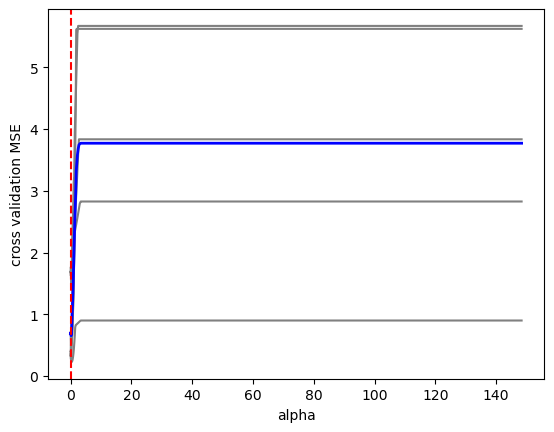

In [54]:
fig, ax = plt.subplots()

ax.plot(lasso_cv.alphas_, lasso_cv.mse_path_, color='grey')
ax.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), color='blue', linewidth=2)
ax.axvline(x = lasso_cv.alpha_, color='red', linestyle='dashed')
ax.set_xlabel('alpha')
ax.set_ylabel('cross validation MSE')

plt.show()

We therefore need to STRETCH the small values of `alpha` and compress the large values of `alpha`. Let's plot the results with respect to the NATURAL LOG of `alpha`. We can now see the TUNED LOG-`alpha` value that MINIMIZES the AVERAGE MSE across the 5 folds!

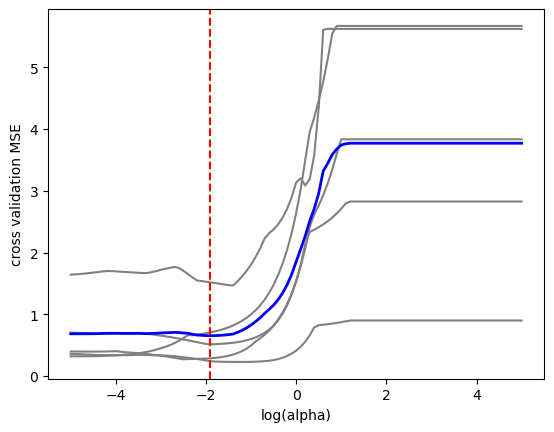

In [55]:
fig, ax = plt.subplots()

ax.plot(np.log(lasso_cv.alphas_), lasso_cv.mse_path_, color='grey')
ax.plot(np.log(lasso_cv.alphas_), lasso_cv.mse_path_.mean(axis=1), color='blue', linewidth=2)
ax.axvline(x = np.log(lasso_cv.alpha_), color='red', linestyle='dashed')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('cross validation MSE')

plt.show()

However, let's instead plot the MSE results with respect to the NEGATIVE LOG `alpha`. This effectively FLIPS the axis ordering putting SMALL `alpha` valuse on the RIGHT and LARGE `alpha` values on the LEFT. The figure below is now organized in a manner similar to how we visualized the REGULARIZATION results associated with the `C` parameter in logistic regression! High regularization and thus ZERO coefficients are on the LEFT side of the plot while the low regularization and thus potentially OVERFIT results are on the right side of the plot. The BEST result is somewhere in the middle!

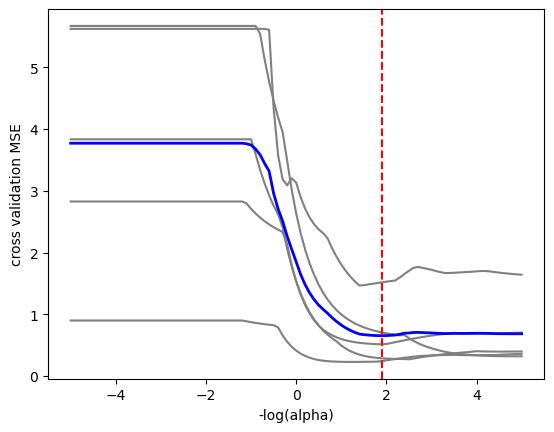

In [56]:
fig, ax = plt.subplots()

ax.plot(-np.log(lasso_cv.alphas_), lasso_cv.mse_path_, color='grey')
ax.plot(-np.log(lasso_cv.alphas_), lasso_cv.mse_path_.mean(axis=1), color='blue', linewidth=2)
ax.axvline(x = -np.log(lasso_cv.alpha_), color='red', linestyle='dashed')
ax.set_xlabel('-log(alpha)')
ax.set_ylabel('cross validation MSE')

plt.show()

### Elastic net

ELASTIC NET penalized linear regession models are fit much the same way as the RIDGE and LASSO models. 

In [57]:
from sklearn.linear_model import ElasticNet

The ELASTIC NET penalty involves 2 parameters. The `alpha` parameter and the `l1_ratio` parameter. The `l1_ratio` parameter is the SAME parameter as `l1_ratio` in `LogisticRegression()`. It controls the MIXING FRACTION between RIDGE and LASSO.

The ELASTIC NET penalized model with `alpha=1` and `l1_ratio=0.5` is fit below.

In [58]:
enet_default = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=25001, fit_intercept=False).fit( X_sk, y_sk.ravel() )

In [59]:
enet_default.coef_

array([0.        , 0.58917239, 0.        , 0.        , 0.        ,
       0.        , 0.34261901, 0.        , 0.01564731])

The ELASTIC NET model can be tuned via the built in cross-validation scheme.

In [60]:
from sklearn.linear_model import ElasticNetCV

BOTH `alpha` and `l1_ratio` must be tuned. A grid of 7 evenly spaced values between 0.01 and 1.0 are defined below to tune for `l1_ratio`. The lower bound is very close to zero but not quite zero on purpose. The `ElasticNet()` and `ElasticNetCV()` functions can have issues when fitting if `l1_ratio=0`.

In [61]:
mixing_grid = np.linspace(0.01, 1.0, num=7)

In [62]:
enet_cv = ElasticNetCV(alphas=alpha_grid, l1_ratio=mixing_grid, max_iter=50001, fit_intercept=False).fit( X_sk, y_sk.ravel() )

The tuned Elastic Net model has a low `alpha` value and has been converted to Lasso!

In [63]:
enet_cv.alpha_

0.006737946999085467

In [64]:
enet_cv.l1_ratio_

1.0

In [65]:
enet_cv.coef_

array([ 0.        ,  1.38516487, -0.22588665, -0.        , -0.03952052,
       -0.16134275,  0.56884718, -0.19376145,  0.39092139])

## Pipelines and Grid Search

The built-in cross-validation functions are EASY to use. However, they are not entirely correct. As discussed in the lecture example it is CRITICAL to STANDARDIZE the features BEFORE fitting a REGULARIZED model! The same concept applies to REGRESSION!

We therefore need to create a PIPELINE that manages the preprocessing and fitting the model appropriately within the folds of the cross-validation scheme.

We will use the Pipeline function to manage these operations.

In [66]:
from sklearn.pipeline import Pipeline

In [67]:
from sklearn.model_selection import GridSearchCV

### Pre-made design matrix

As discussed in lecture, we need to REMOVE the INTERCEPT or BIAS column from the FEATURE array. We need to do this because we are standardizing and the INTERCEPT or BIAS column has a single value! The unique values of the ZEROTH column in `X_sk` are shown below to confirm this.

In [68]:
np.unique( X_sk[:, 0] )

array([1.])

The first few rows of the first five columns are displayed below as another confirmation.

In [69]:
X_sk[:5, :5]

array([[ 1.        ,  1.024252  ,  1.04909217, -0.65062286,  0.42331011],
       [ 1.        , -1.73367102,  3.00561521,  0.99390354,  0.98784425],
       [ 1.        , -0.08929361,  0.00797335,  0.2518047 ,  0.06340561],
       [ 1.        , -1.09374794,  1.19628455,  1.35654252,  1.84020762],
       [ 1.        ,  0.32099527,  0.10303796, -0.14512101,  0.02106011]])

The zeroth column is removed and the result is assigned to the `X_sk_b` array.

In [70]:
X_sk_b = X_sk[:, 1:].copy()

We will standardize the FEATURES before fitting a model. We therefore need the `StandardScaler()` function.

In [71]:
from sklearn.preprocessing import StandardScaler

We need to use the typical scikit-learn approach where the intercept is estimated separately from the rest of the coefficients. Therefore, let's initialize the LASSO model that sets `fit_intercept` to `True`.

In [72]:
lasso_to_fit = Lasso(max_iter=25001, fit_intercept=True)

Let's now define the PIPELINE or WORKFLOW which standardizes the FEATURES and then FITS a Lasso model. This Pipeline therefore has 2 steps. Those two steps are named `'std_features'` and `lasso'` below.

In [73]:
lasso_wflow = Pipeline( steps=[('std_features', StandardScaler()), 
                               ('lasso', lasso_to_fit)])

In [74]:
lasso_wflow

Pipeline(steps=[('std_features', StandardScaler()),
                ('lasso', Lasso(max_iter=25001))])

Define the tuning grid for the workflow with the dictionary containing a single ITEM (KEY/VALUE pair). The KEY uses the naming convention of:

`<PIPELINE STEP NAME>__<PARAMETER NAME in step>`

We are tuning `alpha` within the `'lasso'` step. Thus, the tuning parameter is named: `lasso__alpha` There are 2 underscores or "DUNDERS" between the STEP NAME and PARAMETER NAME. The `alpha_grid` defined earlier is used again below.

In [75]:
lasso_grid = {'lasso__alpha': alpha_grid}

Initialize the grid search and define the `scoring` argument to be `'neg_root_mean_squared_error'`. This forces `GridSearchCV()` to find the optimal `alpha` value that MAXIMIZES the NEGATIVE RMSE (which is equivalent to MINIMIZING the RMSE).

In [76]:
lasso_search = GridSearchCV(lasso_wflow, param_grid=lasso_grid, cv=kf, scoring='neg_root_mean_squared_error')

Execute the cross-validation.

In [77]:
lasso_search_results = lasso_search.fit( X_sk_b, y_sk.ravel() )

The TUNED `alpha` value is provided below by the `.best_params_` attribute.

In [78]:
lasso_search_results.best_params_

{'lasso__alpha': 0.0301973834223185}

The best score associated with that tuned value is:

In [79]:
lasso_search_results.best_score_

-0.7874943700751234

Since this is the NEGATIVE RMSE, the AVERAGE RMSE associated with the BEST `alpha` is:

In [80]:
-lasso_search_results.best_score_

0.7874943700751234

We can access the underlying LASSO model via the `.best_estimator.named_steps` dictionary. We must use the STEP NAME as the KEY.

In [81]:
lasso_search_results.best_estimator_.named_steps['lasso']

Lasso(alpha=0.0301973834223185, max_iter=25001)

The coeficient estimates associated with this tuned `alpha` are shown below.

In [82]:
lasso_search_results.best_estimator_.named_steps['lasso'].coef_

array([ 1.47442903, -0.00988932,  0.        , -0.        ,  0.        ,
        0.56834214, -0.        ,  0.32975209])

The intercept associated with the tuned `alpha` is shown below.

In [83]:
lasso_search_results.best_estimator_.named_steps['lasso'].intercept_

-0.09086687115588199

How does this optimal LASSO model behave? Let's use PREDICTIONS to find out!

The cell below defines a grid of input values focusing on the `x1` input.

In [88]:
input_grid_1 = pd.DataFrame([ (x1, x2) for x1 in np.linspace(df.x1.min(), df.x1.max(), num=101) 
                                       for x2 in np.linspace(df.x2.min(), df.x2.max(), num=9)],
                             columns=['x1', 'x2'])

In [89]:
input_grid_1.nunique()

x1    101
x2      9
dtype: int64

The FEATURE array associated with this input grid is created using the `dmatrix()` function.

In [90]:
from patsy import dmatrix

In [91]:
Xgrid_1 = dmatrix( ' ~ ( x1 + np.power(x1, 2) ) * ( x2 + np.power(x2, 2) )', data = input_grid_1 )

In [92]:
Xgrid_1.shape

(909, 9)

The ZEROTH column in the FEATURE ARRAY corresponds to the INTERCEPT or BIAS column.

In [93]:
Xgrid_1[:5, :5]

array([[ 1.        , -1.73367102,  3.00561521, -1.81332966,  3.28816446],
       [ 1.        , -1.73367102,  3.00561521, -1.2693435 ,  1.61123293],
       [ 1.        , -1.73367102,  3.00561521, -0.72535735,  0.52614328],
       [ 1.        , -1.73367102,  3.00561521, -0.18137119,  0.03289551],
       [ 1.        , -1.73367102,  3.00561521,  0.36261497,  0.13148961]])

Remove it!

In [94]:
Xgrid_1_b = Xgrid_1[:, 1:].copy()

The GRID SEARCH OBJECT, `lasso_search_results`, is a FULL model. It has a `.predict()` method! Predicting the visualization grid requires providing `Xgrid_1_b` as the argument to the `.predict()` method. Please note that the PIPELINE will STANDARDIZE the features **based** on the TRAINING set! Therefore, you do NOT need to standardize the features! The GRID SEARCH OBJECT will take care of it for you!

In [95]:
dfviz_1 = input_grid_1.copy()

In [96]:
dfviz_1['pred_lasso_tune'] = lasso_search_results.predict( Xgrid_1_b )

In [97]:
dfviz_1

,x1,x2,pred_lasso_tune
0,-1.733671,-1.813330,-3.186044
1,-1.733671,-1.269344,-2.982954
2,-1.733671,-0.725357,-2.851541
3,-1.733671,-0.181371,-2.791805
4,-1.733671,0.362615,-2.803746
...,...,...,...
904,1.822354,0.362615,2.752595
905,1.822354,0.906601,3.431635
906,1.822354,1.450587,4.692748
907,1.822354,1.994573,6.535936


The predictions are visualized below!

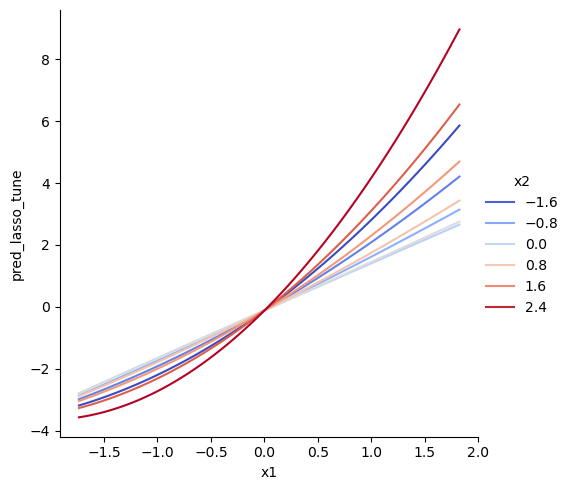

In [98]:
sns.relplot(data = dfviz_1, x='x1', y='pred_lasso_tune', kind='line',
            hue='x2', estimator=None, units='x2',
            palette='coolwarm')

plt.show()

The predictions are NOT straight lines! We created this data set in Week 11. We specified the TRUE formula as LINEAR ADDITIVE FEATURES and thus the correct answer are straight lines! So is the tuned LASSO method wrong? Remember there are ONLY 35 measurements in this example! We do NOT have a lot of data! 

Thus, what really matters is how does the tuned LASSO model compare to the original UNREGULARIZED complex model? The model that was fit by ONLY minimizing the LOSS? Let's find out by predicting the TRENDS with that original model. We could the statsmodel, `fit_stats`or or the sklearn model, `fit_sk`, to do this.

In [99]:
dfviz_1['pred_complex'] = fit_stats.predict( input_grid_1 )

The `dfviz_1` DataFrame is reshaped to LONG-FORMAT to GATHER the two columns with the PREDICTIONS. The INPUTS `x1` and `x2` are NOT gathered.

In [100]:
dfviz_1.reset_index().rename(columns={'index':'rowid'}).melt(id_vars=['rowid', 'x1', 'x2'])

,rowid,x1,x2,variable,value
0,0,-1.733671,-1.813330,pred_lasso_tune,-3.186044
1,1,-1.733671,-1.269344,pred_lasso_tune,-2.982954
2,2,-1.733671,-0.725357,pred_lasso_tune,-2.851541
3,3,-1.733671,-0.181371,pred_lasso_tune,-2.791805
4,4,-1.733671,0.362615,pred_lasso_tune,-2.803746
...,...,...,...,...,...
1813,904,1.822354,0.362615,pred_complex,1.470184
1814,905,1.822354,0.906601,pred_complex,2.629134
1815,906,1.822354,1.450587,pred_complex,5.345968
1816,907,1.822354,1.994573,pred_complex,9.620687


The LONG FORMAT data allows associating the model the predictions come from with the facet! The figure below shows that tuned LASSO model "supresses" the very curved trends associated with the original complex model! The LASSO penalty has therefore simplified the complex model!

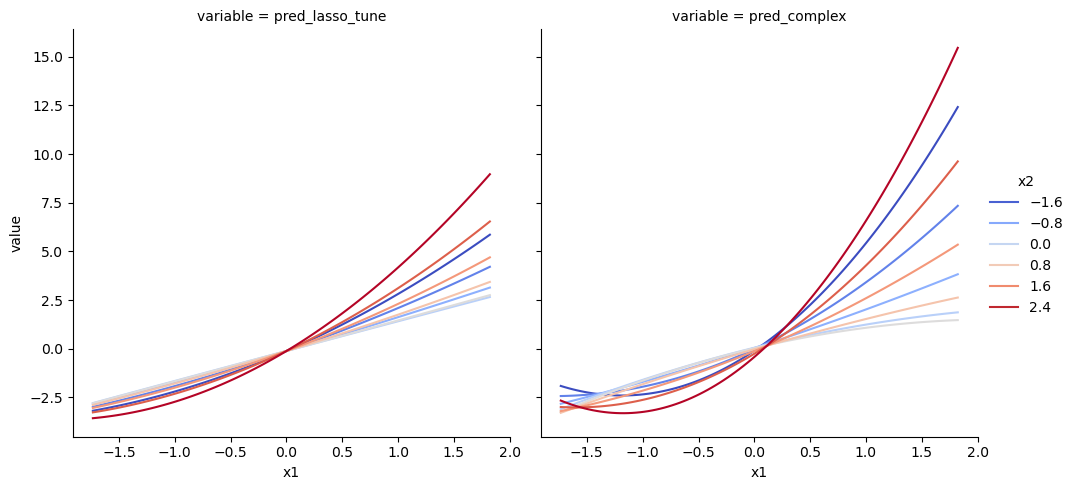

In [101]:
sns.relplot(data = dfviz_1.reset_index().rename(columns={'index':'rowid'}).melt(id_vars=['rowid', 'x1', 'x2']), 
            x='x1', y='value', col='variable',
            kind='line',
            hue='x2', estimator=None, units='x2',
            palette='coolwarm')

plt.show()

### Polynomial Features

We used the formula interface in `dmatrices()` to create the FEATURES associated with the complex model. However, we can NEARLY create those features as a PREPROCESSING step within a Pipeline via the `PolynomialFeatures()` function. You will see below why I use the term NEARLY, but this is another approach that enables bypassing the "helper" functions of `dmatrices()` and `dmatrix()`.

The `PolynomialFeatures()` function is imported below.

In [102]:
from sklearn.preprocessing import PolynomialFeatures

The `PolynomialFeatures()` function generates POLYNOMIALS of a specified DEGREE (power) for the COLUMNS in an array. We therefore need an array of the INPUTS. A DataFrame of INPUTS is created below.

In [103]:
xinputs = df.drop(columns=['y']).copy()

In [104]:
xinputs.head()

,x1,x2
0,1.024252,-0.650623
1,-1.733671,0.993904
2,-0.089294,0.251805
3,-1.093748,1.356543
4,0.320995,-0.145121


The INPUT DataFrame is converted to NumPy array.

In [105]:
X_train = xinputs.to_numpy()

The output `y` is also converted to a 1D NumPy array.

In [106]:
youtputs = df.y

In [107]:
y_train = youtputs.to_numpy().ravel()

In [108]:
X_train.shape

(35, 2)

In [109]:
y_train.shape

(35,)

The `PolynomialFeatures()` function is used below to generate all polynomials UP TO the second degree for the INPUTS contained in `X_train`. The `.fit_transform()` method is applied to generate all features derived from the 2 inputs with `degree=2`.

In [110]:
PolynomialFeatures(degree=2).fit_transform( X_train )[:5, :]

array([[ 1.        ,  1.024252  , -0.65062286,  1.04909217, -0.66640177,
         0.42331011],
       [ 1.        , -1.73367102,  0.99390354,  3.00561521, -1.72310177,
         0.98784425],
       [ 1.        , -0.08929361,  0.2518047 ,  0.00797335, -0.02248455,
         0.06340561],
       [ 1.        , -1.09374794,  1.35654252,  1.19628455, -1.48371558,
         1.84020762],
       [ 1.        ,  0.32099527, -0.14512101,  0.10303796, -0.04658316,
         0.02106011]])

What's going on with `PolynomialFeatures()`? Let's simplify things by modifying the arguments. The `interaction_only` argument allows returning LINEAR MAIN EFFECTS and INTERACTIONS up to a specified degree. Keeping `degree=2` with `interaction_only=True` returns the following array. The ZEROTH column only contains 1 because the ZEROTH column is the INTERCEPT or BIAS column! The next two columns are the INPUT values and the last column is the PRODUCT or MULTIPLICATION or INTERACTION between the two!

In [111]:
PolynomialFeatures(degree=2, interaction_only=True).fit_transform( X_train )[:5, :]

array([[ 1.        ,  1.024252  , -0.65062286, -0.66640177],
       [ 1.        , -1.73367102,  0.99390354, -1.72310177],
       [ 1.        , -0.08929361,  0.2518047 , -0.02248455],
       [ 1.        , -1.09374794,  1.35654252, -1.48371558],
       [ 1.        ,  0.32099527, -0.14512101, -0.04658316]])

Let's remove the INTERCEPT or BIAS column by setting `include_bias=False`. The result only consists of the FEATURES!

In [112]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform( X_train )[:5, :]

array([[ 1.024252  , -0.65062286, -0.66640177],
       [-1.73367102,  0.99390354, -1.72310177],
       [-0.08929361,  0.2518047 , -0.02248455],
       [-1.09374794,  1.35654252, -1.48371558],
       [ 0.32099527, -0.14512101, -0.04658316]])

Let's now return to including the POLYNOMIALS with the MAIN EFFECTS and INTERACTION. There are 5 columns because we have the LINEAR MAIN EFFECTS for both inputs, the QUADRATIC FEATURES for both inputs, and the INTERACTION between them. Thus, `PolynomialFeatures()` creates all 5 features associated with 2nd degree polynomials!

In [113]:
PolynomialFeatures(degree=2, include_bias=False).fit_transform( X_train )[:5, :]

array([[ 1.024252  , -0.65062286,  1.04909217, -0.66640177,  0.42331011],
       [-1.73367102,  0.99390354,  3.00561521, -1.72310177,  0.98784425],
       [-0.08929361,  0.2518047 ,  0.00797335, -0.02248455,  0.06340561],
       [-1.09374794,  1.35654252,  1.19628455, -1.48371558,  1.84020762],
       [ 0.32099527, -0.14512101,  0.10303796, -0.04658316,  0.02106011]])

The "complex" formula we used for our model involves each of the features generated by `PolynomialFeatures()`. However, we also interacted the quadratic features with the linear main effects and with each other! The coefficient estimates with their names are displayed below as a reminder.

In [114]:
fit_stats.params

Intercept                          0.048390
x1                                 1.355946
np.power(x1, 2)                   -0.287992
x2                                -0.030340
np.power(x2, 2)                   -0.061388
x1:x2                             -0.229695
x1:np.power(x2, 2)                 0.641887
np.power(x1, 2):x2                -0.229303
np.power(x1, 2):np.power(x2, 2)    0.458874
dtype: float64

Creating these specific features together via `PolynomialFeatures()` is very challenging. We can generate all of those features but only if features we did not include in the formula are also present. The `PolynomialFeatures()` function will generate all features up to and including 4th degree polynomials by specifying `degree=4`. However, as shown below this produces many features!

In [115]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform( X_train ).shape

(35, 14)

This model involves 14 features even though there are just 2 inputs! This model therefore involves estimating 15 coefficients (one for each feature plus the intercept). The number of regression coefficients that must be estimated is nearly equal to HALF the training data! This is a very complex model! 

We can fit such a model since there are still more data points than unknowns.

In [116]:
X_very_complex = PolynomialFeatures(degree=4, include_bias=False).fit_transform( X_train )

In [117]:
fit_very_complex_sk = LinearRegression(fit_intercept=True).fit( X_very_complex, y_train )

All coefficients are estimated.

In [118]:
fit_very_complex_sk.intercept_

0.09591624306582977

In [119]:
fit_very_complex_sk.coef_

array([ 0.87812526,  0.25690528,  0.04969575, -0.30546506, -0.51409257,
        0.25433278, -0.22137715,  0.68557457, -0.14928366, -0.13542088,
       -0.01017214,  0.4918648 ,  0.02309851,  0.11368033])

The training set R-squared appears to be quite high.

In [120]:
fit_very_complex_sk.score( X_very_complex, y_train )

0.9343239898655243

But, let's TUNE a LASSO model to see if ALL features are truly necessary! We will define a NEW workflow which generates the polynomials features as part of the PIPELINE! This way we do NOT need to keep creating the FEATURE array using either `dmatrices()` or the `PolynomialFeatures()` function! The features are generated from the INPUTS as part of the model!

This new workflow will involve 4 steps. The first step standardizes the inputs, the second step generates the polynomial features, the third step standardizes those features, and the last step fits the lasso model.

In [121]:
lasso_4th_wflow = Pipeline( steps=[('std_inputs', StandardScaler()), 
                                   ('make_poly', PolynomialFeatures(degree=4, include_bias=False)), 
                                   ('std_features', StandardScaler()), 
                                   ('lasso', lasso_to_fit)])

In [122]:
lasso_4th_wflow

Pipeline(steps=[('std_inputs', StandardScaler()),
                ('make_poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('std_features', StandardScaler()),
                ('lasso', Lasso(max_iter=25001))])

Let's use the same `alpha` grid and cross-validation scheme as before.

In [123]:
lasso_4th_search = GridSearchCV( lasso_4th_wflow, param_grid=lasso_grid, cv=kf, scoring='neg_root_mean_squared_error' )

We can now execute the cross-validation! However, we do NOT need to provide `X_very_complex` to fit the model! The features are generated as part of the model! Therefore, we only need to provide the INPUTS array!

In [124]:
lasso_4th_search_results = lasso_4th_search.fit( X_train, y_train )

In [125]:
lasso_4th_search_results.best_params_

{'lasso__alpha': 0.1826835240527347}

In [126]:
lasso_4th_search_results.best_score_

-0.8285294753063004

The intercept associated with this tuned `alpha` is below.

In [127]:
lasso_4th_search_results.best_estimator_.named_steps['lasso'].intercept_

-0.09086687115588199

But, what really matters are the coefficient estimates associated with the tuned `alpha`. As shown below, most of the coefficients are ZERO! Therefore, LASSO has turned MOST of the features OFF!

In [128]:
lasso_4th_search_results.best_estimator_.named_steps['lasso'].coef_

array([ 1.06095643,  0.        ,  0.        ,  0.        , -0.        ,
        0.53511252,  0.        ,  0.12225403,  0.        ,  0.        ,
        0.01587903,  0.        ,  0.        , -0.        ])

What does this model look like? Let's find out by making predictions! We do NOT need to generate the features from the inputs because the features are created by the PIPELINE. Therefore, we only need to convert the `input_grid_1` DataFrame to a NumPy array when making predictions!

In [129]:
dfviz_1['pred_lasso_4th_tune'] = lasso_4th_search_results.predict( input_grid_1.to_numpy() )

In [130]:
dfviz_1

,x1,x2,pred_lasso_tune,pred_complex,pred_lasso_4th_tune
0,-1.733671,-1.813330,-3.186044,-1.911260,-3.844108
1,-1.733671,-1.269344,-2.982954,-2.429809,-3.599911
2,-1.733671,-0.725357,-2.851541,-2.827037,-3.436202
3,-1.733671,-0.181371,-2.791805,-3.102943,-3.352981
4,-1.733671,0.362615,-2.803746,-3.257528,-3.350248
...,...,...,...,...,...
904,1.822354,0.362615,2.752595,1.470184,3.497955
905,1.822354,0.906601,3.431635,2.629134,3.582006
906,1.822354,1.450587,4.692748,5.345968,3.750662
907,1.822354,1.994573,6.535936,9.620687,4.003922


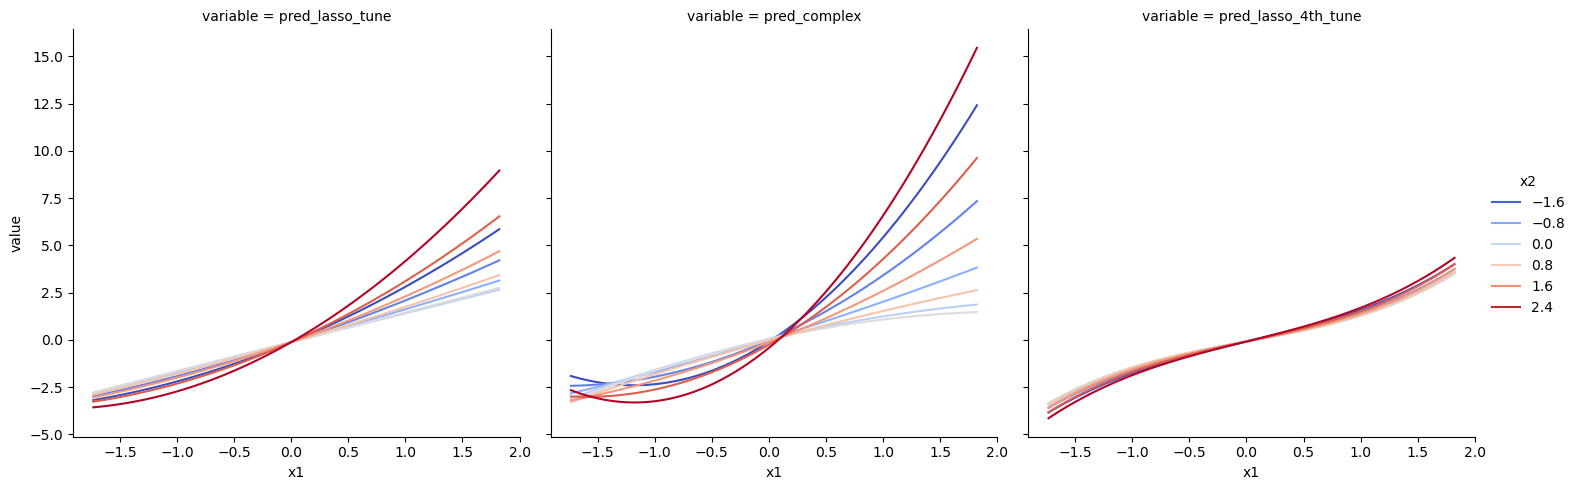

In [131]:
sns.relplot(data = dfviz_1.reset_index().rename(columns={'index':'rowid'}).melt(id_vars=['rowid', 'x1', 'x2']), 
            x='x1', y='value', col='variable',
            kind='line',
            hue='x2', estimator=None, units='x2',
            palette='coolwarm')

plt.show()

The tuned lasso penalty applied to the VERY COMPLEX set of polynomial features produced a model that actually looks more linear than the previous lasso model! This last model included even more polynomials and thus would NOT look like this WITHOUT the tuned LASSO penalty!

## Summary

This notebook demonstrated the basic syntax for fitting and tuning REGULARIZED regression models. In concluded by showing how to generate polynomial features as part of the modeling PIPELINE.